In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
MNIST_train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

In [3]:
MNIST_train.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [5]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets

In [16]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])
X_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
len(MNIST_train.classes)

10

In [7]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons, n_classes):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(56, 10)

In [8]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)

In [9]:
import numpy as np

batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test
y_test = y_test

for epoch in range(20):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        #print(X_batch.shape)
        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    #(accuracy)

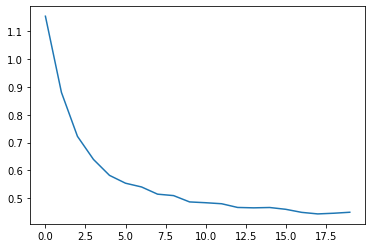

In [10]:
with torch.no_grad():
    plt.plot(test_loss_history)
    plt.show()

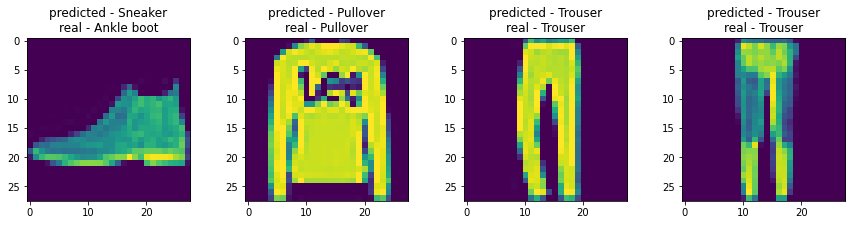

In [11]:
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    for i in range(4):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')

show_sample(mnist_net, X_test, y_test, MNIST_test)

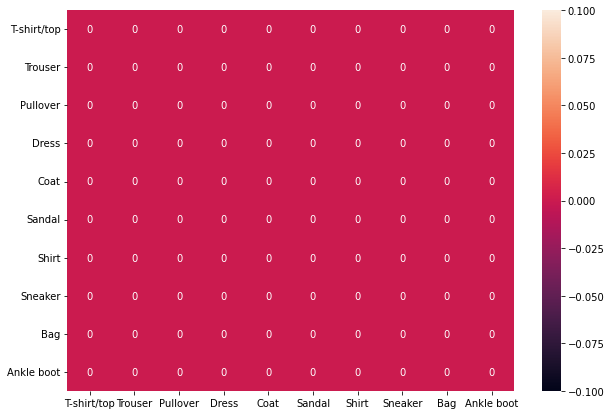

In [17]:
import seaborn as sns
import pandas as pd
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes

    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.show()

show_matrix(mnist_net, X_test, y_test, MNIST_test)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [27]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [28]:
len(MNIST_train.classes)

10

In [29]:
class MNIST_ConV(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 80)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(80, 40)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(40, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

mnist_conv = MNIST_ConV()

In [30]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=1.0e-3)

In [32]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

for epoch in range(20):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = mnist_conv.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = mnist_conv.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    #print(accuracy)

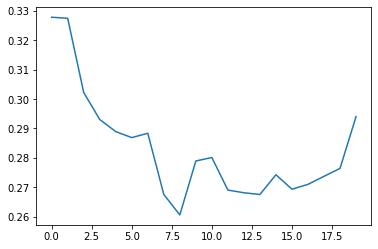

In [33]:
with torch.no_grad():
    plt.plot(test_loss_history)
    plt.show()

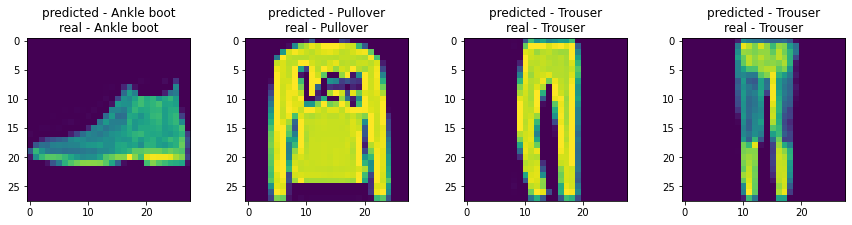

In [35]:
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    for i in range(4):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')

show_sample(mnist_conv, X_test, y_test, MNIST_test)

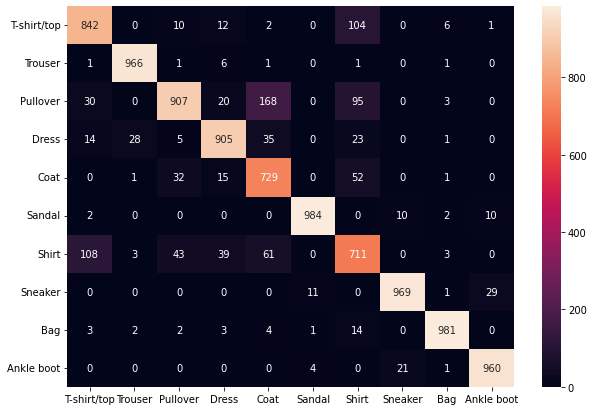

In [36]:
import seaborn as sns
import pandas as pd
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes

    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.show()

show_matrix(mnist_conv, X_test, y_test, MNIST_test)

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)